In [1]:
import glob
import time
import numpy as np
import random
import cv2 as cv
import matplotlib.pyplot as plt
import keras
import keras.backend as K
from keras.models import Model, load_model
from keras.layers import Activation, Input, Dense, Conv2D, Conv2DTranspose, Dropout, LeakyReLU
from keras.regularizers import l1
from keras.optimizers import Adam
from keras.callbacks import ModelCheckpoint, TerminateOnNaN, TensorBoard
from sklearn.manifold import TSNE
from collections import defaultdict

Using TensorFlow backend.


# Define utility and training functions

In [2]:
def get_dimensions(files):
    min_height, min_width = 10000, 10000
    max_height, max_width = 0, 0
    for f in files:
        img = cv.imread(f)
        h,w = img.shape[:2]
        if h < min_height:
            min_height = h
        if h > max_height:
            max_height = h
        if w < min_width:
            min_width = w
        if w > max_width:
            max_width = w
    return min_height, min_width, max_height, max_width

def make_train_val(files):
    num_files = len(files)
    train = files[:int(.6*num_files)]
    val = files[int(.6*num_files):]
    return train, val

def get_batches(files, batch_size, resize_size, num_color_channels, augment=False):
    count = 0
    batch_out = np.zeros((batch_size, resize_size[0], resize_size[1], num_color_channels), dtype=np.uint8)
    num_files = len(files)
    while True:
        f = files[count%num_files]
        img = cv.imread(f)        
        res = cv.resize(img, resize_size)
        
        # Augment by randomly flipping the image
        if augment and random.choice([True, False]):
            res = cv.flip(res, random.choice([-1, 0, 1]))
        
        if num_color_channels == 1:
            res = cv.cvtColor(res, cv.COLOR_BGR2GRAY)
            res = res[...,None]
        batch_out[count%batch_size,...] = res
        count += 1
        if count%batch_size == 0:
            yield batch_out.astype(np.float)/255., batch_out.astype(np.float)/255.
            
# Autoencoder based on convolution and deconvolution
class autoencoder_conv():
    def __init__(self,
                 input_shape,
                 n_enc_conv_layers=2, # each layer is followed by a Pooling layer
                 n_enc_conv_filters=[32]*2, # individually customizable
                 enc_kernel_size=[(3,2)]*2, # list of integers or tuples
                 n_dec_conv_filters=[32]*2,
                 dec_kernel_size=[(3,2)]*2,
                 dropout=[0.0]*4, # individually customizable
                 strides=[(2,1)]*2,
                 activation='relu',
                 kernel_initializer='glorot_uniform',
                 l1_reg=0.0,
                 lr=0.001
                ):

        if len(n_enc_conv_filters) == 1:
            n_enc_conv_filters = n_enc_conv_filters*n_enc_conv_layers

        if len(enc_kernel_size) == 1:
            enc_kernel_size = enc_kernel_size*n_enc_conv_layers

        if len(n_dec_conv_filters) == 1:
            n_dec_conv_filters = n_dec_conv_filters*n_enc_conv_layers

        if len(dec_kernel_size) == 1:
            dec_kernel_size = dec_kernel_size*n_enc_conv_layers

        if len(dropout) == 1:
            dropout = dropout*(2*n_enc_conv_layers)

        if len(strides) == 1:
            strides = strides*n_enc_conv_layers

        self.input_shape=input_shape
        self.n_enc_conv_layers=n_enc_conv_layers
        self.n_enc_conv_filters=n_enc_conv_filters
        self.enc_kernel_size=enc_kernel_size
        self.n_dec_conv_filters=n_dec_conv_filters
        self.dec_kernel_size=dec_kernel_size
        self.dropout=dropout
        self.strides=strides
        self.activation=activation
        self.kernel_initializer = kernel_initializer
        self.l1_reg=l1_reg
        self.lr=lr
        self.model = self.get_model()

    def get_model(self):
        I = Input(shape=self.input_shape, name='input')
        # start encoder
        E_in = I
        for i in range(self.n_enc_conv_layers):
            E_in = Conv2D(self.n_enc_conv_filters[i], self.enc_kernel_size[i], strides=self.strides[i], padding='same',
                            data_format='channels_last', kernel_initializer=self.kernel_initializer,
                            kernel_regularizer=l1(self.l1_reg), name='encoder_{}'.format(i))(E_in)
            if self.activation == 'LeakyReLU':
                E_in = LeakyReLU()(E_in)
            else:
                E_in = Activation(self.activation)(E_in)
            E_in = Dropout(self.dropout[i])(E_in)
        
        # start decoder
        D_in = E_in
        for i in range(self.n_enc_conv_layers-1):
            D_in = Conv2DTranspose(self.n_dec_conv_filters[i], self.dec_kernel_size[i], strides=self.strides[-1-i], padding='same',
                             data_format='channels_last', kernel_initializer=self.kernel_initializer,
                             kernel_regularizer=l1(self.l1_reg))(D_in)
            if self.activation == 'LeakyReLU':
                D_in = LeakyReLU()(D_in)
            else:
                D_in = Activation(self.activation)(D_in)
            D_in = Dropout(self.dropout[i])(D_in)

        O = Conv2D(self.input_shape[2], (3,3), padding='same', data_format='channels_last',
                         activation='sigmoid', kernel_initializer=self.kernel_initializer,
                         kernel_regularizer=l1(self.l1_reg), name='output')(D_in)
        
        model = Model(inputs=I, outputs=O)
        model.compile(loss='binary_crossentropy', optimizer=Adam(lr=self.lr), metrics=['mse'])
        return model
    
def train(train_files, val_files, epochs=100, batch_size=8, common_size=(128,128), num_color_channels=3, new_model=True, save_model_name='model_1.hdf5'):
    num_batches_per_epoch = len(train_files)//batch_size
    
    train_batch_generator = get_batches(train_files, batch_size, common_size, num_color_channels, True)
    val_batch_generator = get_batches(val_files, batch_size, common_size, num_color_channels)

    checkpt = ModelCheckpoint(save_model_name, monitor='val_loss', verbose=1, save_best_only=True, mode='auto')
    
    if new_model: # create a new model
        model = autoencoder_conv([common_size[0], common_size[1], num_color_channels],
                                 n_enc_conv_layers=12,
                                 n_enc_conv_filters=[64]*11+[1],
                                 enc_kernel_size=[(3,3)],
                                 n_dec_conv_filters=[64]*11,
                                 dec_kernel_size=[(3,3)],
                                 dropout=[0.0],
                                 strides=([(1,1)]*2+[(2,2)])*4,
                                 activation='LeakyReLU',
                                 kernel_initializer='glorot_uniform',
                                 l1_reg=1e-5,
                                 lr=0.0001).model
    else: # continue to train a previous model
        print('Continuing training from a previous model')
        model = load_model('models/'+save_model_name)

    model.summary()
    model.fit_generator(train_batch_generator, steps_per_epoch=num_batches_per_epoch, epochs=epochs,
                        verbose=1, callbacks=[checkpt, TerminateOnNaN(), TensorBoard(log_dir='logs/')], 
                        validation_data=val_batch_generator, validation_steps=len(val_files)//batch_size)
    return model

# Training Autoencoder

The autoencoder performs dimensionality reduction so we can better perform clustering

In [3]:
imgs = glob.glob('Images//12242018_to_12251028//*.jpg')

# Get initial look at the range of the pictures sizes
# min_h, min_w, max_h, max_w = get_dimensions(imgs)
# print('Minimum height = {}, minimum width = {}, maximum height = {}, maximum width = {}'.format(min_h, min_w, max_h, max_w))

# Trains an autoencoder
train_files, val_files = make_train_val(imgs)
model = train(train_files, val_files, epochs=300, batch_size=32, num_color_channels=3, new_model=True, save_model_name='desktop_model_with_augmentation_1.hdf5')

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input (InputLayer)           (None, 128, 128, 3)       0         
_________________________________________________________________
encoder_0 (Conv2D)           (None, 128, 128, 64)      1792      
_________________________________________________________________
leaky_re_lu_1 (LeakyReLU)    (None, 128, 128, 64)      0         
_________________________________________________________________
dropout_1 (Dropout)          (None, 128, 128, 64)      0         
_________________________________________________________________
encoder_1 (Conv2D)           (None, 128, 128, 64)      36928     
_________________________________________________________________
leaky_re_lu_2 (LeakyReLU)    (None, 128, 128, 64)      0         
_________________________________________________________________
dropout_2 (Dropout)          (None, 128, 128, 64)      0         
__________

Epoch 1/300
210/210 [==============================] - 36s 171ms/step - loss: 0.5187 - mean_squared_error: 0.0543 - val_loss: 0.3338 - val_mean_squared_error: 0.0036

Epoch 00001: val_loss improved from inf to 0.33383, saving model to desktop_model_with_augmentation_1.hdf5
Epoch 2/300
210/210 [==============================] - 34s 163ms/step - loss: 0.3114 - mean_squared_error: 0.0031 - val_loss: 0.2914 - val_mean_squared_error: 0.0027

Epoch 00002: val_loss improved from 0.33383 to 0.29140, saving model to desktop_model_with_augmentation_1.hdf5
Epoch 3/300
210/210 [==============================] - 35s 165ms/step - loss: 0.2762 - mean_squared_error: 0.0025 - val_loss: 0.2627 - val_mean_squared_error: 0.0024

Epoch 00003: val_loss improved from 0.29140 to 0.26266, saving model to desktop_model_with_augmentation_1.hdf5
Epoch 4/300
210/210 [==============================] - 34s 163ms/step - loss: 0.2531 - mean_squared_error: 0.0024 - val_loss: 0.2447 - val_mean_squared_error: 0.0022

Epo


Epoch 00030: val_loss improved from 0.15161 to 0.15055, saving model to desktop_model_with_augmentation_1.hdf5
Epoch 31/300
210/210 [==============================] - 33s 159ms/step - loss: 0.1499 - mean_squared_error: 0.0020 - val_loss: 0.1493 - val_mean_squared_error: 0.0020

Epoch 00031: val_loss improved from 0.15055 to 0.14934, saving model to desktop_model_with_augmentation_1.hdf5
Epoch 32/300
210/210 [==============================] - 33s 159ms/step - loss: 0.1490 - mean_squared_error: 0.0020 - val_loss: 0.1486 - val_mean_squared_error: 0.0020

Epoch 00032: val_loss improved from 0.14934 to 0.14859, saving model to desktop_model_with_augmentation_1.hdf5
Epoch 33/300
210/210 [==============================] - 33s 159ms/step - loss: 0.1481 - mean_squared_error: 0.0020 - val_loss: 0.1476 - val_mean_squared_error: 0.0020

Epoch 00033: val_loss improved from 0.14859 to 0.14760, saving model to desktop_model_with_augmentation_1.hdf5
Epoch 34/300
210/210 [=============================

210/210 [==============================] - 33s 159ms/step - loss: 0.1356 - mean_squared_error: 0.0019 - val_loss: 0.1353 - val_mean_squared_error: 0.0019

Epoch 00060: val_loss improved from 0.13559 to 0.13533, saving model to desktop_model_with_augmentation_1.hdf5
Epoch 61/300
210/210 [==============================] - 33s 159ms/step - loss: 0.1353 - mean_squared_error: 0.0019 - val_loss: 0.1352 - val_mean_squared_error: 0.0019

Epoch 00061: val_loss improved from 0.13533 to 0.13515, saving model to desktop_model_with_augmentation_1.hdf5
Epoch 62/300
210/210 [==============================] - 33s 159ms/step - loss: 0.1351 - mean_squared_error: 0.0019 - val_loss: 0.1350 - val_mean_squared_error: 0.0020

Epoch 00062: val_loss improved from 0.13515 to 0.13502, saving model to desktop_model_with_augmentation_1.hdf5
Epoch 63/300
210/210 [==============================] - 33s 159ms/step - loss: 0.1348 - mean_squared_error: 0.0019 - val_loss: 0.1347 - val_mean_squared_error: 0.0019

Epoch 00


Epoch 00089: val_loss did not improve from 0.13125
Epoch 90/300
210/210 [==============================] - 33s 159ms/step - loss: 0.1312 - mean_squared_error: 0.0019 - val_loss: 0.1311 - val_mean_squared_error: 0.0019

Epoch 00090: val_loss improved from 0.13125 to 0.13113, saving model to desktop_model_with_augmentation_1.hdf5
Epoch 91/300
210/210 [==============================] - 33s 159ms/step - loss: 0.1311 - mean_squared_error: 0.0019 - val_loss: 0.1310 - val_mean_squared_error: 0.0019

Epoch 00091: val_loss improved from 0.13113 to 0.13103, saving model to desktop_model_with_augmentation_1.hdf5
Epoch 92/300
210/210 [==============================] - 33s 159ms/step - loss: 0.1310 - mean_squared_error: 0.0019 - val_loss: 0.1310 - val_mean_squared_error: 0.0019

Epoch 00092: val_loss improved from 0.13103 to 0.13096, saving model to desktop_model_with_augmentation_1.hdf5
Epoch 93/300
210/210 [==============================] - 33s 159ms/step - loss: 0.1310 - mean_squared_error: 0.0


Epoch 00119: val_loss improved from 0.12943 to 0.12943, saving model to desktop_model_with_augmentation_1.hdf5
Epoch 120/300
210/210 [==============================] - 33s 159ms/step - loss: 0.1294 - mean_squared_error: 0.0019 - val_loss: 0.1293 - val_mean_squared_error: 0.0019

Epoch 00120: val_loss improved from 0.12943 to 0.12935, saving model to desktop_model_with_augmentation_1.hdf5
Epoch 121/300
210/210 [==============================] - 33s 159ms/step - loss: 0.1294 - mean_squared_error: 0.0019 - val_loss: 0.1293 - val_mean_squared_error: 0.0019

Epoch 00121: val_loss improved from 0.12935 to 0.12933, saving model to desktop_model_with_augmentation_1.hdf5
Epoch 122/300
210/210 [==============================] - 33s 159ms/step - loss: 0.1293 - mean_squared_error: 0.0019 - val_loss: 0.1293 - val_mean_squared_error: 0.0019

Epoch 00122: val_loss improved from 0.12933 to 0.12929, saving model to desktop_model_with_augmentation_1.hdf5
Epoch 123/300
210/210 [=========================


Epoch 00183: val_loss did not improve from 0.12784
Epoch 184/300
210/210 [==============================] - 33s 158ms/step - loss: 0.1279 - mean_squared_error: 0.0018 - val_loss: 0.1278 - val_mean_squared_error: 0.0018

Epoch 00184: val_loss improved from 0.12784 to 0.12781, saving model to desktop_model_with_augmentation_1.hdf5
Epoch 185/300
210/210 [==============================] - 33s 159ms/step - loss: 0.1279 - mean_squared_error: 0.0018 - val_loss: 0.1279 - val_mean_squared_error: 0.0018

Epoch 00185: val_loss did not improve from 0.12781
Epoch 186/300
210/210 [==============================] - 33s 159ms/step - loss: 0.1278 - mean_squared_error: 0.0018 - val_loss: 0.1278 - val_mean_squared_error: 0.0018

Epoch 00186: val_loss did not improve from 0.12781
Epoch 187/300
210/210 [==============================] - 33s 158ms/step - loss: 0.1278 - mean_squared_error: 0.0018 - val_loss: 0.1278 - val_mean_squared_error: 0.0018

Epoch 00187: val_loss improved from 0.12781 to 0.12776, sav

210/210 [==============================] - 33s 159ms/step - loss: 0.1273 - mean_squared_error: 0.0018 - val_loss: 0.1273 - val_mean_squared_error: 0.0018

Epoch 00250: val_loss did not improve from 0.12721
Epoch 251/300
210/210 [==============================] - 33s 159ms/step - loss: 0.1273 - mean_squared_error: 0.0018 - val_loss: 0.1272 - val_mean_squared_error: 0.0018

Epoch 00251: val_loss did not improve from 0.12721
Epoch 252/300
210/210 [==============================] - 33s 159ms/step - loss: 0.1272 - mean_squared_error: 0.0018 - val_loss: 0.1272 - val_mean_squared_error: 0.0018

Epoch 00252: val_loss did not improve from 0.12721
Epoch 253/300
210/210 [==============================] - 33s 159ms/step - loss: 0.1272 - mean_squared_error: 0.0018 - val_loss: 0.1272 - val_mean_squared_error: 0.0018

Epoch 00253: val_loss did not improve from 0.12721
Epoch 254/300
210/210 [==============================] - 33s 159ms/step - loss: 0.1272 - mean_squared_error: 0.0018 - val_loss: 0.1272

# View Autoencoder Output

View the quality of the dimensionality reduction by looking at how how well the original images can be reconstructed from the lower dimension information

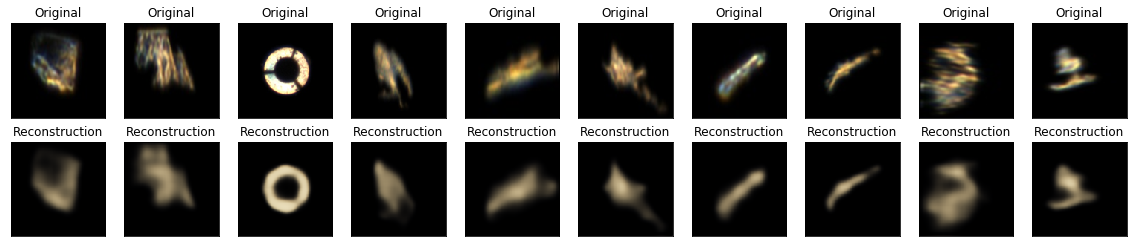

In [11]:
model = load_model('models/desktop_model_with_augmentation_1.hdf5')
batch_size = 10
g = get_batches(train_files, batch_size, (128,128), num_color_channels=3)
for i in range(np.random.randint(len(train_files)//batch_size)):
    x_test, _ = next(g)
decoded_imgs = model.predict(x_test)

plt.figure(figsize=(20, 4))
for i in range(batch_size):
    # display original
    ax = plt.subplot(2, batch_size, i+1)
    plt.imshow(np.uint8(x_test[i,...,::-1]*255))
    ax.set_title('Original')
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)

    # display reconstruction
    ax = plt.subplot(2, batch_size, i + batch_size + 1)
    plt.imshow(np.uint8(decoded_imgs[i,...,::-1]*255))
    ax.set_title('Reconstruction')
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)
plt.show()

# Perform Clustering

In this section, each image is passed through a trained autoencoder to reduce its dimension. Then a clustering algorithm is performed on the lower dimension vectors to group similar images.

In [3]:
# First, load the trained autoencoder model and grab the encoder layer associated with the smallest dimension
model = load_model('models/desktop_model_with_augmentation_1.hdf5')
model.summary()
enc_layer = model.get_layer('encoder_11')

# Create a Keras model with model input and encoder output
encoder = Model(inputs=model.input, outputs=enc_layer.output)

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input (InputLayer)           (None, 128, 128, 3)       0         
_________________________________________________________________
encoder_0 (Conv2D)           (None, 128, 128, 64)      1792      
_________________________________________________________________
leaky_re_lu_1 (LeakyReLU)    (None, 128, 128, 64)      0         
_________________________________________________________________
dropout_1 (Dropout)          (None, 128, 128, 64)      0         
_________________________________________________________________
encoder_1 (Conv2D)           (None, 128, 128, 64)      36928     
_________________________________________________________________
leaky_re_lu_2 (LeakyReLU)    (None, 128, 128, 64)      0         
_________________________________________________________________
dropout_2 (Dropout)          (None, 128, 128, 64)      0         
__________

In [4]:
# Next, read in the pictures that are to be clustered
imgs = glob.glob('Images//12242018_to_12251028//*.jpg')

# Run the images through the encoder to reduce their dimensions
g = get_batches(imgs, 1, (128,128), num_color_channels=3)
for i in range(len(imgs)):
    x_test, _ = next(g)
    if i == 0:
        reduced_dims = encoder.predict(x_test).reshape(1,-1)
    else:
        reduced_dims = np.vstack((reduced_dims,encoder.predict(x_test).reshape(1,-1)))
print(reduced_dims.shape)

(11229, 64)


## Train T-SNE Algorithm

In [5]:
# build the tsne model on the reduced dimensions
print('building tsne model')
tsne_model = TSNE(n_components=2, n_iter=10000, perplexity=10, learning_rate=50) #perplexity=10, learning_rate=5
start = time.time()    
np.set_printoptions(suppress=True)
img_embedding = tsne_model.fit_transform(reduced_dims)
print('KL Divergence {}'.format(tsne_model.kl_divergence_))
print('tsne fit time: {}'.format(time.time()-start))

building tsne model
KL Divergence 2.533406972885132
tsne fit time: 980.8803961277008


SPCP2-1545750101-023700-000-1692-256-104-160.jpg
SPCP2-1545748985-014854-000-2184-2068-128-120.jpg
SPCP2-1545765483-040840-001-1864-1064-120-224.jpg


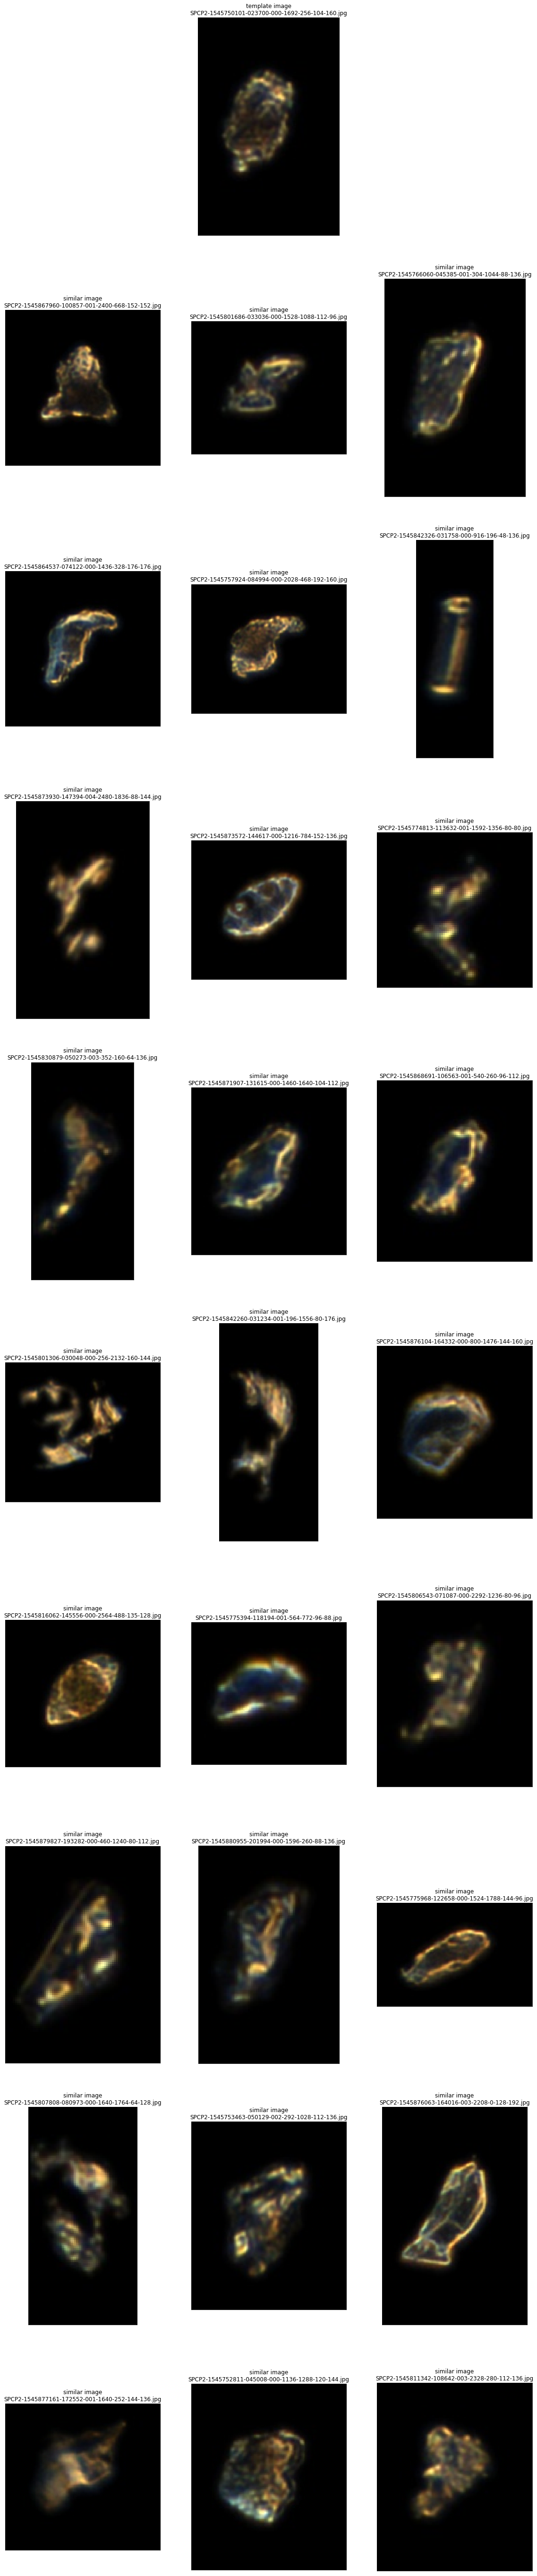

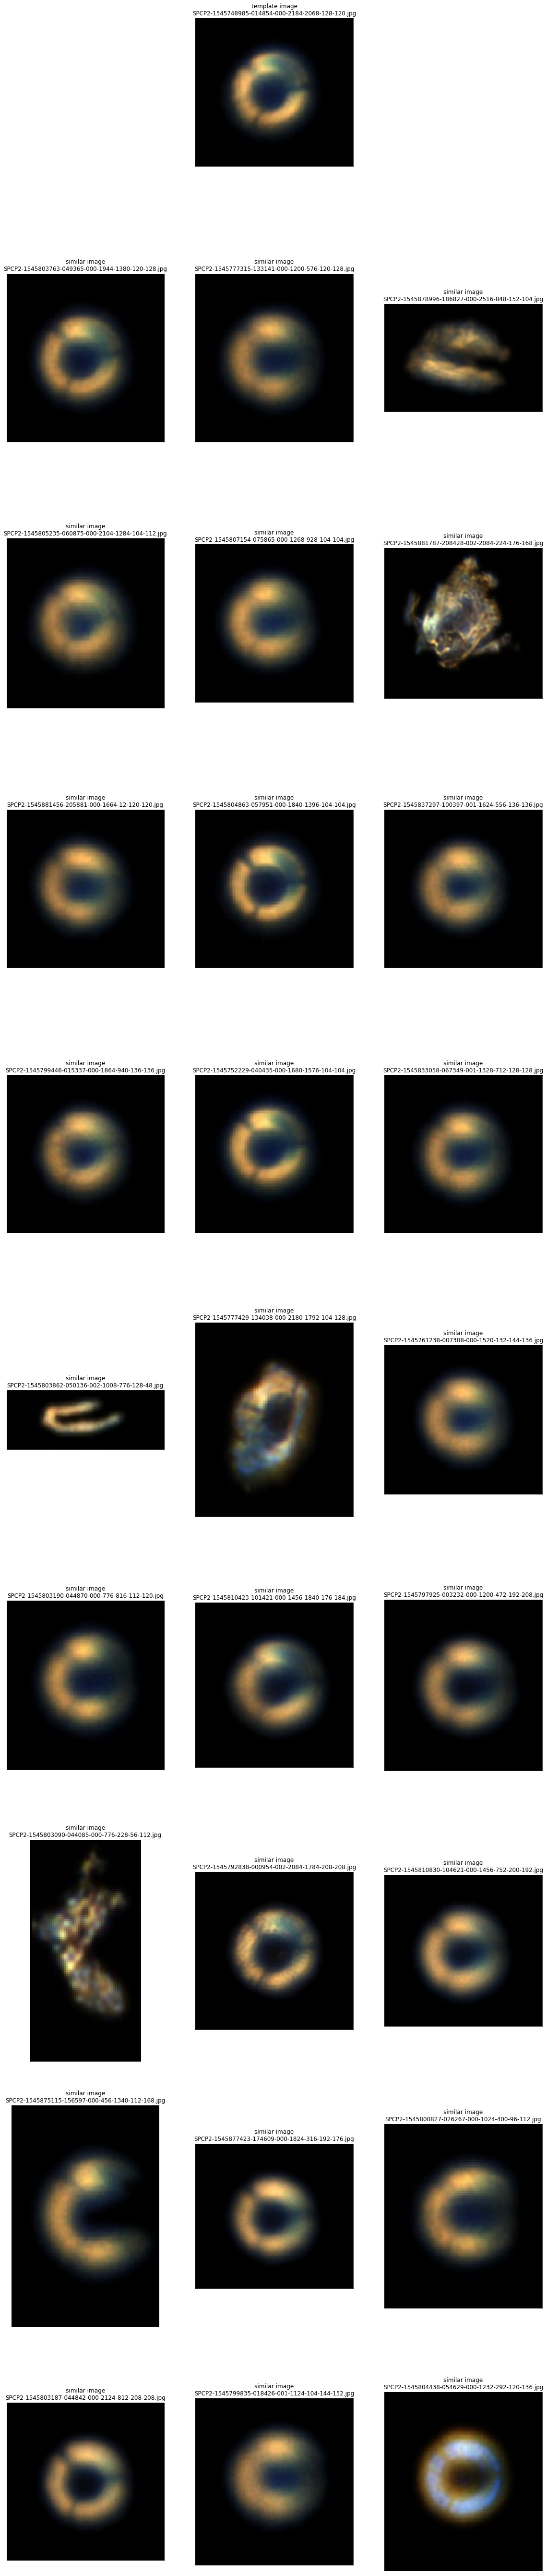

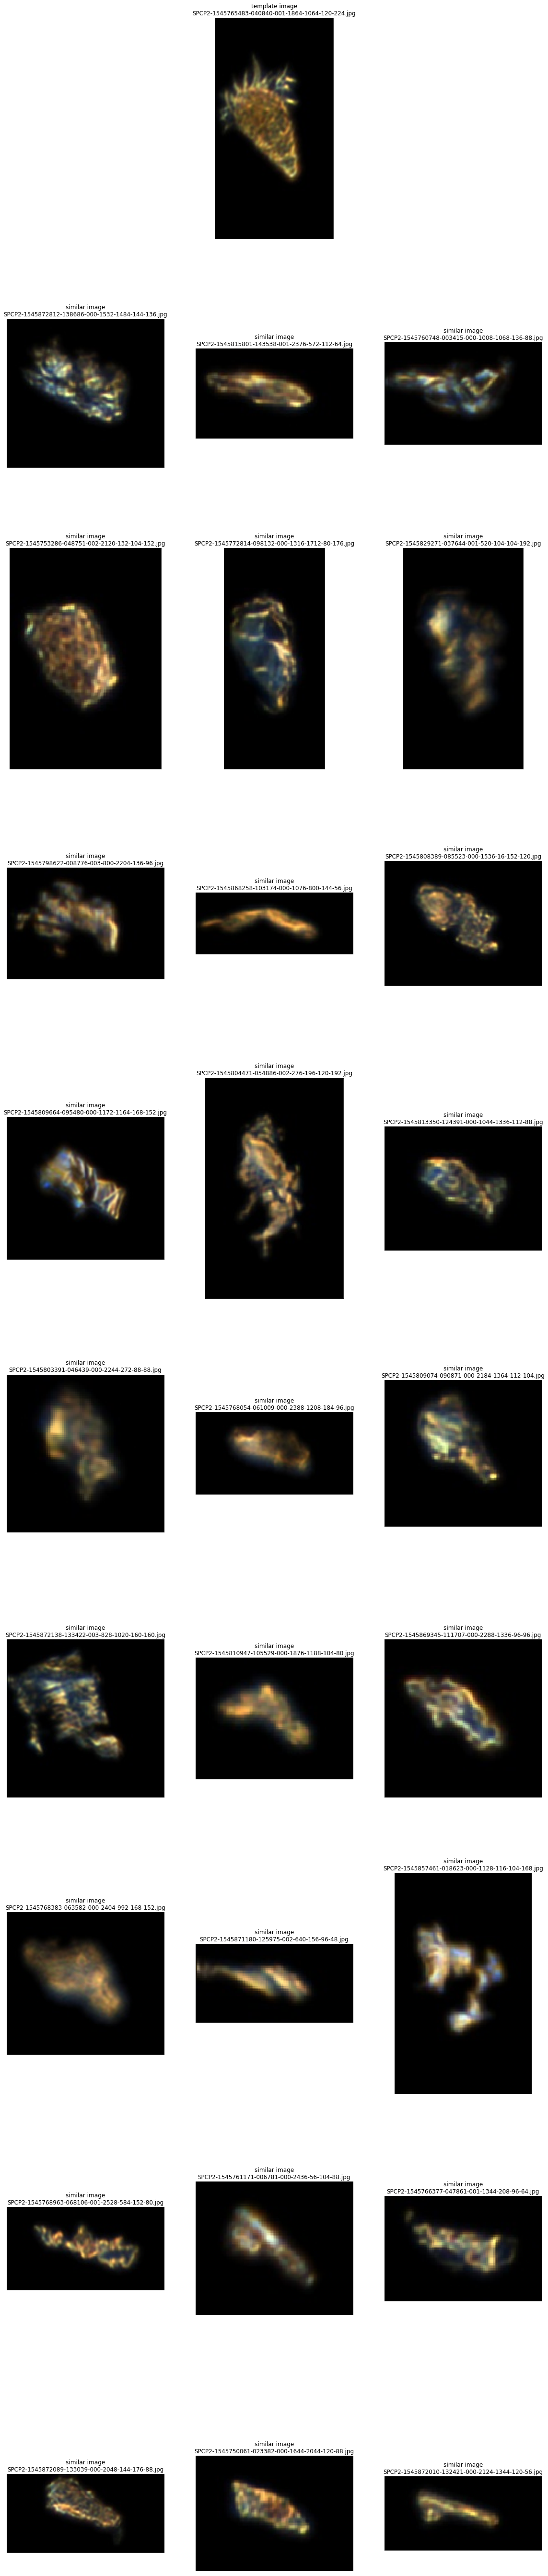

In [7]:
template_names = ['SPCP2-1545750101-023700-000-1692-256-104-160.jpg',
                  'SPCP2-1545748985-014854-000-2184-2068-128-120.jpg',
                  'SPCP2-1545765483-040840-001-1864-1064-120-224.jpg']
for tn in template_names:
    print(tn)
    idx = [ii for ii,f in enumerate(imgs) if tn in f]
    template_img = imgs[idx[0]]
    template_embedding = img_embedding[idx]
    dist = np.linalg.norm(template_embedding-img_embedding, axis=1)
    sort_idx = np.argsort(dist)
    similar_imgs = [imgs[si] for si in sort_idx[1:]]
    
    # Show template image
    plt.figure(figsize=(20, 100))
    ax = plt.subplot(10,3,2)
    plt.imshow(cv.imread(template_img)[...,::-1])
    ax.set_title('template image\n{}'.format(template_img.split('/')[-1]))
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)
    
    # Show some similar images
    for i in range(27):
        ax = plt.subplot(10,3,i+4)
        plt.imshow(cv.imread(similar_imgs[i])[...,::-1])
        ax.set_title('similar image\n{}'.format(similar_imgs[i].split('/')[-1]))
        ax.get_xaxis().set_visible(False)
        ax.get_yaxis().set_visible(False)        